Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [148]:
%%time
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time
users = pd.read_csv('ml-users.csv') 
#display(users)

CPU times: user 7.77 ms, sys: 16.4 ms, total: 24.1 ms
Wall time: 28.9 ms


In [3]:
# the interactions table should really have the following header (but doesn't currently)
# audit_task_interaction_id, audit_task_id, action, gsv_panorama_id, lat, lng, heading, pitch, zoom, note, 
# timestamp, temporary_label_id, mission_id 

# I had to turn off exceptions because of parsing problems, including:
# https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues/3
# col_names = ['audit_task_interaction_id', 'audit_task_id', 'action', 'gsv_panorama_id', 'lat', 'lng', 
#            'heading', 'pitch', 'zoom', 'note', 'timestamp', 'temporary_label_id', 'mission_id']
# interactions = pd.read_csv('ml-interactions5000.csv', error_bad_lines=False,
#                           header=None, names = col_names, index_col=False) 
#interactions = pd.read_csv('ml-interactions5000.csv')

In [4]:
%%time
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip') # load the full gzip tarball
#interactions = pd.read_csv('ml-interactions15000.csv')
#display(df_interactions.head())

# Do a little cleanup...
# In my initial analysis, i found that at least one row has a NaN value for an 'action' field. This should
# not happen. So, let's find that row (and others) that have this problem and remove them

# pd.isna checks for missing values (NaN values). It returns a boolean array where the index corresponds to
# row and the value corresponds to True/False indicating whether there is a NaN value
isna_result = pd.isna(df_interactions['action'])

print("Printing all rows where 'action' == NaN...")
display(df_interactions[isna_result])
df_interactions= df_interactions[~isna_result] # we want all rows where isna is False (that is, all rows *without* a NaN for 'action')

# As a test, we can again look for NaN 'action' cells
isna_result = pd.isna(df_interactions['action'])
print("Printing all rows where 'action' == NaN... there should be no rows")
display(df_interactions[isna_result])


Printing all rows where 'action' == NaN...


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id
18502779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Printing all rows where 'action' == NaN... there should be no rows


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id


CPU times: user 51.4 s, sys: 17.9 s, total: 1min 9s
Wall time: 1min 14s


In [8]:
df_interactions.head()

,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id
0,2019-04-25 18:56:51.007-07,bf16418a-4c99-4fd6-99c6-7e8b40fbe17b,10829973.0,3458.0,LowLevelEvent_mousemove,yswXpbti65Rk8pcuuB5IAQ,47.629299,-122.301750,178.535721,-6.598214,2.0,"cursorX:600,cursorY:421",NaN,2740.0
1,2019-04-25 18:56:51.102-07,bf16418a-4c99-4fd6-99c6-7e8b40fbe17b,10830000.0,3458.0,POV_Changed,yswXpbti65Rk8pcuuB5IAQ,47.629299,-122.301750,183.178574,-6.598214,2.0,NaN,NaN,2740.0
2,2019-04-25 18:56:56.289-07,2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,10830056.0,3463.0,POV_Changed,Br6DzMb4z7VHPJoqJv-w5Q,47.680912,-122.319862,174.540176,-18.908482,1.0,NaN,NaN,2747.0
3,2019-04-25 18:56:51.985-07,bf16418a-4c99-4fd6-99c6-7e8b40fbe17b,10830121.0,3458.0,LowLevelEvent_mouseout,yswXpbti65Rk8pcuuB5IAQ,47.629299,-122.301750,183.178574,-6.598214,2.0,"cursorX:641,cursorY:163",NaN,2740.0
4,2019-04-25 18:56:56.523-07,2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,10830133.0,3463.0,LowLevelEvent_mousemove,Br6DzMb4z7VHPJoqJv-w5Q,47.680912,-122.319862,151.477676,-20.220982,1.0,"cursorX:709,cursorY:426",NaN,2747.0


In [12]:
assert sum(df_interactions['action'].isna()) == 0

In [157]:
def scatter(series, name):
    fig, ax = plt.subplots()
    ax.set_xlabel(name)
    ax.set_ylabel('accuracy')
    slope, intercept, r_value, p_value, std_err = stats.linregress(series, users_merged[' accuracy'])
    p = np.poly1d([slope, intercept])
    ax.plot(series, p(series), 'r--')
    ax.scatter(series, users_merged[' accuracy'])

In [ ]:
# analyze avg num of mouse moves per pano vs accuracy

In [17]:
df_interactions.groupby('user_id')

In [137]:
selection = df_interactions[['user_id', 'action', 'gsv_panorama_id']]

In [55]:
keyboard_counts = selection.groupby('user_id').apply(lambda x: sum(x['action'].isin(['LowLevelEvent_keydown', 'KeyboardShortcut_ModeSwitch_NoSidewalk'])))

In [152]:
users = users.set_index('user_id')

In [153]:
users

,username,labels_validated,role,accuracy
user_id,,,,
0e1ae564-6d72-4670-98e4-71369cc5ab26,AHLS6AZ1VTNH7,472,Turker,74.955595
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,A1A73A5Z4SDW06,393,Turker,84.551148
49723673-044d-4b47-855b-3bdebfe37073,shaunkuo,518,Registered,82.817869
7b1596af-14d4-4f2b-9e4e-71b1884db836,A1EK8YNHZHTW1J,98,Turker,82.178218
86d26e9d-010f-4802-88ba-680ae0a8e20d,A2AHXGFXPG6ZSR,157,Turker,38.497653
87833d72-b357-4e2c-81cd-23f58ff04c59,jonfroehlich,332,Owner,77.529658
9b595ba6-529b-4d37-93d7-dd189184e15a,kckamin,161,Registered,77.118644
ac272eb8-3bb3-4260-9960-8e6c463f3867,mosharp,90,Registered,80.808081
af812204-1521-4c42-bf88-4baaaffe3f06,A1NOINYD1FZ55T,185,Turker,77.073171


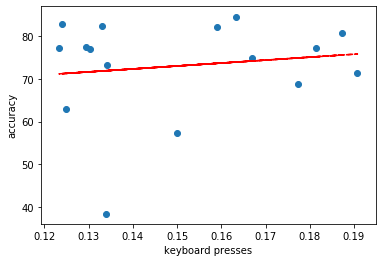

In [158]:
scatter(keyboard_counts, 'keyboard presses')

(array([1., 0., 0., 0., 1., 1., 1., 3., 4., 5.]),
 array([38.49765258, 43.10300215, 47.70835171, 52.31370128, 56.91905084,
        61.5244004 , 66.12974997, 70.73509953, 75.3404491 , 79.94579866,
        84.55114823]),
 <a list of 10 Patch objects>)

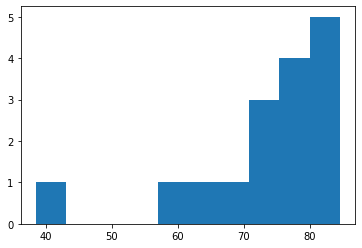

In [68]:
plt.hist(users_merged[' accuracy'])

In [76]:
num_missions = selection.groupby('user_id').apply(lambda x: sum(x['action']=='MissionComplete'))

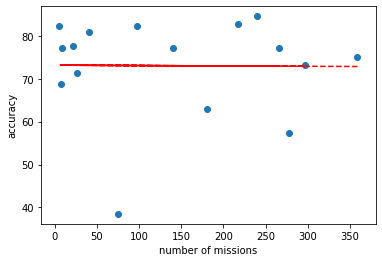

In [156]:
scatter(num_missions, 'number of missions')

Scatter matrix

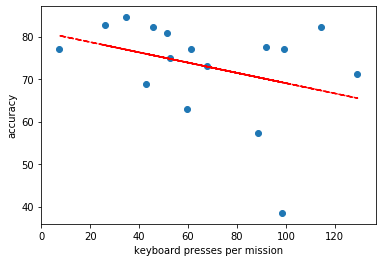

In [131]:
scatter(users_merged['keyboard_per_mission'], 'keyboard presses per mission')

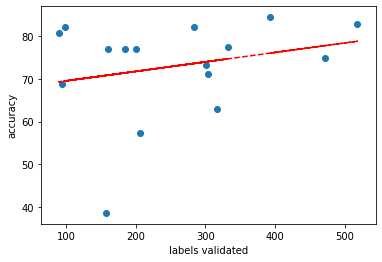

In [133]:
scatter(users_merged[' labels_validated'], 'labels validated')

In [140]:
pov_per_panorama = selection.groupby('user_id').apply(lambda x: sum(x['action'] == 'POV_Changed') / x['gsv_panorama_id'].size)



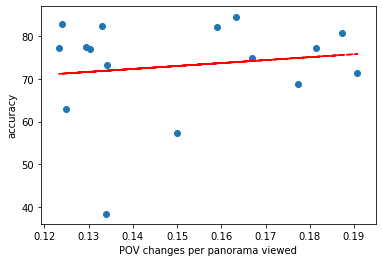

In [143]:
scatter(pov_per_panorama, 'POV changes per panorama viewed')

In [146]:
avg_zoom = df_interactions.groupby('user_id').apply(lambda x: x['zoom'].mean())

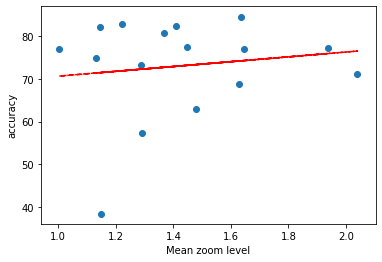

In [147]:
scatter(avg_zoom, 'Mean zoom level')

In [150]:
time.strptime('4/25/2019  6:56:51 PM', '%d/%b/%Y  %H:%M:%S PM')

ValueError: time data '4/25/2019  6:56:51 PM' does not match format '%d/%b/%Y  %H:%M:%S PM'